## Twiss parameters and machine layout plots from [Elegant](https://ops.aps.anl.gov/manuals/elegant_latest/elegant.html) output (using pandas & plotly)

[A. Petrenko](http://www.inp.nsk.su/~petrenko/) (Novosibirsk, 2021-2023)

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from io import StringIO

from IPython.display import Latex
from IPython.display import Image

<a href=https://ops.aps.anl.gov/manuals/elegant_latest/elegant.html>Elegant</a> lattice file:

In [2]:
with open("machine.lte", "r") as f:
    print(f.read())

CAV     : RFCA,  L=0.15, VOLT=200e3,FREQ=700e6,PHASE=0.00106193
D5      : DRIFT, L=0.21                                   
QD1     : QUAD, L=0.18, K1=-7.05620223 
D6      : DRIFT, L=0.12                    
QF1     : QUAD, L=0.18, K1=13.7964021 
QF2     : QUAD, L=0.18, K1=12.0670253 
QF3     : QUAD, L=0.18, K1=13.7964021 
D7      : DRIFT, L=0.22                  
QD2     : QUAD, L=0.2, K1=-3.3450147
D8      : DRIFT, L=1.08                
QD3     : QUAD, L=0.2, K1=-9.16643151    
D9      : DRIFT, L=0.1                
QF4     : QUAD, L=0.2, K1=8.54245738
D10     : DRIFT, L=0.5575              

DB      : SBEND, L=0.88, ANGLE=0.785399, K1=-2.3515579 

D1      : DRIFT, L=0.18
D2      : DRIFT, L=0.105
D3      : DRIFT, L=0.155
D4      : DRIFT, L=0.07

SZ1     : SEXTUPOL, L=0.08, K2=-250
SZ2     : SEXTUPOL, L=0.08, K2=-250
SX1     : SEXTUPOL, L=0.08, K2=160
SX2     : SEXTUPOL, L=0.08, K2=160

BEND1 : LINE=(D1,DB,D2,SZ1,D3,SX1,D4)
BEND2 : LINE=(D4,SX2,D3,SZ2,D2,DB,D1)

DAMP    : LINE=(CAV,D5

In [3]:
with open("twiss.ele", "r") as f:
    print(f.read())

&transmute_elements name=*, type=WATCH, new_type=DRIF &end

&divide_elements
    name = *
    maximum_length = 0.1
&end

&run_setup
    lattice = machine.lte
    magnets = results/beamline.mag
!    centroid = results/beam.cen
!    parameters = results/parameters.sdds
    p_central_mev = 1500.0
    use_beamline = machine
    default_order=2
&end

&twiss_output
    filename = results/twiss.twi
    matched = 1
&end

&floor_coordinates
    filename = results/xyz.sdds
    include_vertices = 0
    vertices_only = 0
    magnet_centers = 0
&end

&run_control &end

&bunched_beam &end

&track &end


Empty the 'results/' folder:

In [4]:
if not os.path.exists("results/"): os.mkdir("results/")
# clear the "results" folder:
for f in glob.glob('results/*'): os.remove(f)

Run Elegant

In [5]:
out = !elegant twiss.ele
print("\n".join(out[-20:]))

&end
Updating floor coordinates
tracking step 1
generating bunch 1
tracking 1 particles
23 Mar 25 11:40:58: This step establishes energy profile vs s (fiducial beam).
23 Mar 25 11:40:58: Rf phases/references reset.
Post-tracking output completed.
Tracking step completed   ET:  00:00:0.045 CP:    0.04 BIO:0 DIO:0 PF:0 MEM:7353


Finished tracking.
End of input data encountered.
statistics:    ET:  00:00:0.045 CP:    0.04 BIO:0 DIO:0 PF:0 MEM:7353
Thanks for using elegant.  Please cite the following reference in your publications:
  M. Borland, "elegant: A Flexible SDDS-Compliant Code for Accelerator Simulation,"
  Advanced Photon Source LS-287, September 2000.
If you use a modified version, please indicate this in all publications.


In [6]:
os.listdir("results")

['xyz.sdds', 'beamline.mag', 'twiss.twi']

In [7]:
# read SDDS-file into pandas dataframe
def sdds2df(sdds_file, columns="all"):
    if columns=="all":
        columns = !sddsquery $sdds_file -columnlist
    col_str = "-col=" + ",".join(columns)
    out = !sdds2stream $sdds_file $col_str -pipe=out
    DATA = StringIO("\n".join(out))
    df = pd.read_csv(DATA, names=columns, sep=r'\s+')
    return df

In [8]:
df_mag = sdds2df('results/beamline.mag')

In [9]:
df_mag.tail(3)

,ElementName,ElementType,s,Profile
1254,D10,DRIF,27.33708,0.0
1255,D10,DRIF,27.33708,0.0
1256,D10,DRIF,27.43000,0.0


In [10]:
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [11]:
#pio.renderers

In [12]:
#pio.renderers.default = "plotly_mimetype+notebook" # both notebook & html from nbconvert are interactive
pio.renderers.default = "svg" # svg figures (for publications)

In [13]:
pio.templates.default = pio.templates["simple_white"]

In [14]:
fig = go.Figure()

mag = go.Scatter(
    x=df_mag.s, y=df_mag.Profile, mode='lines', line_width=2, line_color="gray",
    hovertext=df_mag.ElementName, hoverinfo="text", showlegend=False
)

#fig.add_trace(mag)
#fig.update_layout(yaxis={'visible': False, 'domain': [0,0.2]})

#fig.show()

Reading Twiss output table:

In [15]:
twi = 'results/twiss.twi'
df = sdds2df(twi)

In [16]:
df.tail(3)

,s,betax,alphax,psix,etax,etaxp,xAperture,betay,alphay,psiy,etay,etayp,yAperture,pCentral0,ElementName,ElementOccurence,ElementType,ChamberShape
286,27.244167,4.858976,3.830148e-02,30.023808,9.063422e-07,4.515850e-17,10.0,0.983281,1.962738e-01,17.776424,0.0,0.0,10.0,2935.426143,D10,22,DRIF,?
287,27.337083,4.853637,1.915074e-02,30.042942,9.063422e-07,4.515850e-17,10.0,0.955925,9.813692e-02,17.872411,0.0,0.0,10.0,2935.426143,D10,23,DRIF,?
288,27.430000,4.851858,5.689893e-16,30.062091,9.063422e-07,4.515850e-17,10.0,0.946806,-9.964252e-15,17.970234,0.0,0.0,10.0,2935.426143,D10,24,DRIF,?


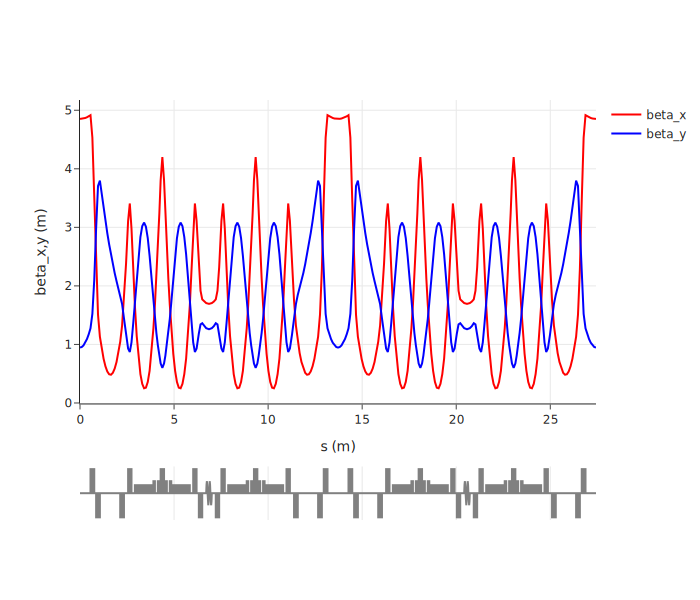

In [17]:
fig = make_subplots(rows=2, shared_xaxes=True, row_heights=[0.85, 0.15])

fig.add_trace( go.Scatter(x=df.s, y=df.betax, mode='lines', line_width=2, line_color="red", name='beta_x')) #r'$\beta_x$') )
fig.add_trace( go.Scatter(x=df.s, y=df.betay, mode='lines', line_width=2, line_color="blue", name='beta_y')) #r'$\beta_y$') )

fig.update_yaxes(title_text="beta_x,y (m)", showgrid=True) # r"$\beta_{x,y}~\mathrm{(m)}$"
fig.update_xaxes(title_text="s (m)", showticklabels=True, showgrid=True)

fig.add_trace(mag, row=2, col=1)

fig.update_traces(xaxis='x')
fig.update_layout(xaxis2={'visible': False}, yaxis2={'visible': False}, hovermode='x unified')

fig.update_layout(height=600)
fig.show()

In [18]:
#fig.show(renderer="svg")

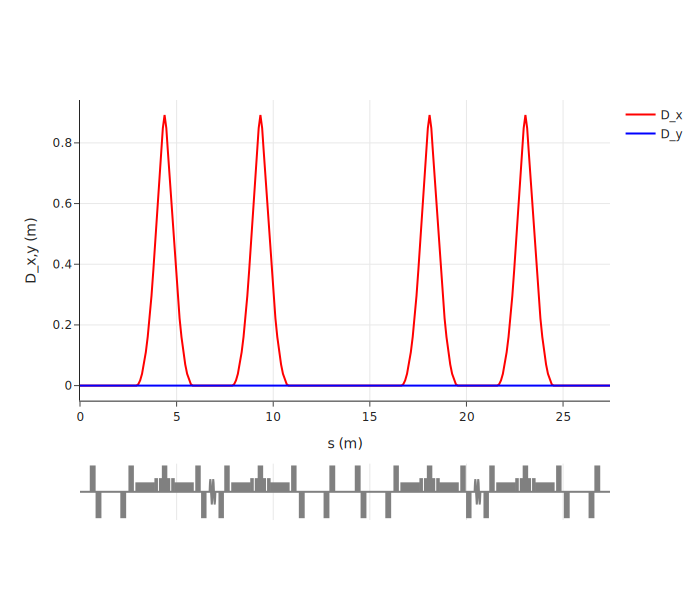

In [19]:
fig = make_subplots(rows=2, shared_xaxes=True, row_heights=[0.8, 0.15])

fig.add_trace( go.Scatter(x=df.s, y=df.etax, mode='lines', line_width=2, line_color="red", name="D_x")) #r'$D_x$') )
fig.add_trace( go.Scatter(x=df.s, y=df.etay, mode='lines', line_width=2, line_color="blue", name="D_y")) #r'$D_y$') )

fig.update_yaxes(title_text="D_x,y (m)", showgrid=True) # r"$D_{x,y}~\mathrm{(m)}$"
fig.update_xaxes(title_text="s (m)", showticklabels=True, showgrid=True)

fig.add_trace(mag, row=2, col=1)

fig.update_traces(xaxis='x')
fig.update_layout(xaxis2={'visible': False}, yaxis2={'visible': False}, hovermode='x unified')

fig.update_layout(height=600)
fig.show()

In [20]:
#fig.show(renderer='svg', width=900, height=600)

## Betatron tunes & chromaticity

In [21]:
def sddspar(file_name, par_name):
    s = !sdds2stream $file_name -par=$par_name
    s = s[0]
    try:
        val = float(s)
        return val
    except (ValueError, TypeError):
        return s

In [22]:
nux=sddspar(twi,'nux')
nuy=sddspar(twi,'nuy')

Latex(r'$\nu_x=%.3f,\ \nu_y=%.3f$' % (nux, nuy))

<IPython.core.display.Latex object>

In [23]:
diag = 'results/resdiag.sdds'
nux_int = np.floor(nux)
nuy_int = np.floor(nuy)

!sddsresdiag $diag -order=8 -integerTunes=$nux_int,$nuy_int -superperiodicity=1

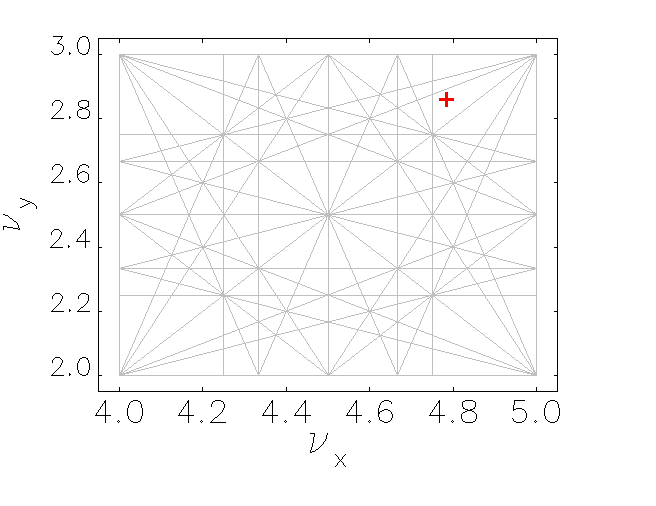

In [24]:
png = "results/image.png"
!sddsplot -device=png -output=$png -split=page \
    -col=nux,nuy -graph=line,type=15 -filter=par,Order,1,4 $diag \
    -par=nux,nuy -graph=sym,type=1,subtype=1,scale=3,thick=3 $twi
Image(png)
# -device=lpng -- for bigger plot

Chromaticity:

In [25]:
Latex(r'$\xi_x=%.2f,\ \xi_y=%.2f$' % (sddspar(twi,'dnux/dp'), sddspar(twi,'dnuy/dp')))

<IPython.core.display.Latex object>

In [26]:
#fig.show(renderer='png', width=900, height=600, scale=1.5)

## Accelerator layout

In [27]:
from scipy import interpolate

def get_mag_3d(ele_folder='',
               Z0=0, X0=0, Y0=0,
               theta0 = 0,
               Element_width = 0.3 # m
              ):
    xyz_file = os.path.join(ele_folder, "results/xyz.sdds")
    mag_file = os.path.join(ele_folder, "results/beamline.mag")
    df_xyz = sdds2df(xyz_file)
    df_mag = sdds2df(mag_file)

    theta = interpolate.interp1d(
        df_xyz.s.values, df_xyz.theta.values,
        fill_value=(0, 0), bounds_error=False
    )

    psi = interpolate.interp1d(
        df_xyz.s.values, df_xyz.psi.values,
        fill_value=(0, 0), bounds_error=False
    )

    Xco = interpolate.interp1d(
        df_xyz.s.values, df_xyz.X.values,
        fill_value=(None, None), bounds_error=False
    )

    Zco = interpolate.interp1d(
        df_xyz.s.values, df_xyz.Z.values,
        fill_value=(None, None), bounds_error=False
    )

    Yco = interpolate.interp1d(
        df_xyz.s.values, df_xyz.Y.values,
        fill_value=(None, None), bounds_error=False
    )

    s = df_mag.s.values
    
    nx =  np.cos(theta(s))*np.sin(psi(s) + np.pi/2)
    nz = -np.sin(theta(s))*np.sin(psi(s) + np.pi/2)
    ny =  np.cos(psi(s) + np.pi/2)

    df_mag['X'] = Xco(s) + Element_width*df_mag['Profile']*nx
    df_mag['Z'] = Zco(s) + Element_width*df_mag['Profile']*nz
    df_mag['Y'] = Yco(s) + Element_width*df_mag['Profile']*ny
    
    Z_old = df_mag.Z.values.copy()
    X_old = df_mag.X.values.copy()
    
    df_mag['Z'] = Z_old*np.cos(theta0) - X_old*np.sin(theta0)
    df_mag['X'] = Z_old*np.sin(theta0) + X_old*np.cos(theta0)

    df_mag['X'] = df_mag['X'] + X0
    df_mag['Z'] = df_mag['Z'] + Z0
    df_mag['Y'] = df_mag['Y'] + Y0
    
    return df_mag

In [28]:
df = get_mag_3d()

In [29]:
df.tail(3)

,ElementName,ElementType,s,Profile,X,Z,Y
1254,D10,DRIF,27.33708,0.0,6.218306e-07,-0.09290,0.0
1255,D10,DRIF,27.33708,0.0,6.218306e-07,-0.09290,0.0
1256,D10,DRIF,27.43000,0.0,-6.629352e-11,0.00002,0.0


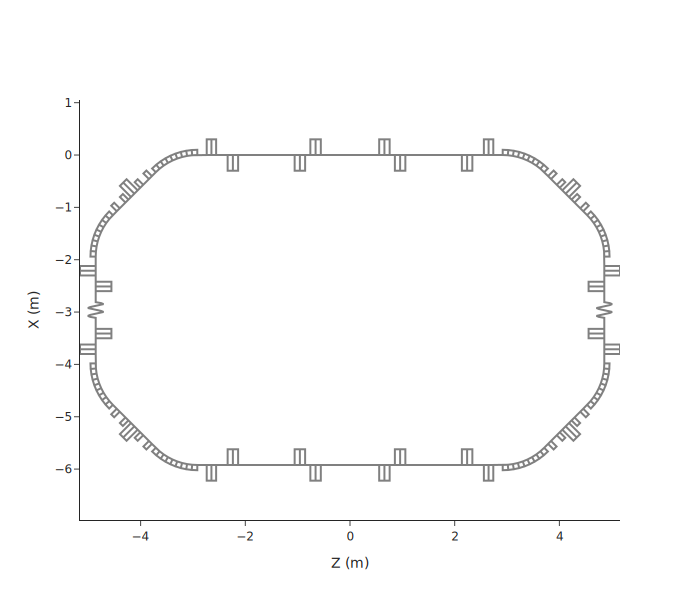

In [30]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.Z, y=df.X, mode='lines', line_width=2, line_color="gray",
        hovertext=df.ElementName,
        hoverinfo="text+x+y"
    )
)

fig.update_xaxes(title_text="Z (m)")
fig.update_yaxes(title_text="X (m)", scaleanchor="x", scaleratio=1)
fig.update_layout(height=600)
fig.show()

In [31]:
#fig.show(renderer='png', width=700, height=500)

In [32]:
%load_ext watermark

In [33]:
%watermark --python --date --iversions --machine

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.27.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.11.0-19-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

pandas : 2.2.2
IPython: 8.27.0
json   : 2.0.9
plotly : 5.24.1
numpy  : 1.26.4
scipy  : 1.13.1
sys    : 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]



In [38]:
!jupyter nbconvert --to HTML Twiss.ipynb

[NbConvertApp] Converting notebook Twiss.ipynb to HTML
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 469339 bytes to Twiss.html


In [35]:
#!jupyter nbconvert --to PDF Twiss.ipynb

In [36]:
pwd

'/data/shared/Acc_Course_2025/2025.03.20_Elegant_Intro/Twiss'

In [37]:
ls -h -all

total 780K
drwxrwxr-x 4 petrenko jupyter 4.0K Mar 23 11:40 ./
drwxrwsr-x 5 petrenko jupyter 4.0K Mar 20 23:55 ../
drwxrwxr-x 2 petrenko jupyter 4.0K Mar 21 09:59 .ipynb_checkpoints/
-rw-r--r-- 1 petrenko jupyter 1.2K Aug  9  2024 machine.lte
drwxrwxr-x 2 petrenko jupyter 4.0K Mar 23 11:41 results/
-rw-r--r-- 1 petrenko jupyter  594 Aug  9  2024 twiss.ele
-rw-rw-r-- 1 petrenko jupyter 361K Mar 23 11:41 Twiss.html
-rw-r--r-- 1 petrenko jupyter 390K Mar 23 11:40 Twiss.ipynb
